# Time Series Analysis with Recurrent Nueral Networks (Keras)

1. Get Data
2. Explore Data
3. Clean and prepare data
4. Split into training and testing sets
5. Assemble Model
6. Train Model
7. Evaluate Model
8. Profit?

## 1. Get Data

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17534615448365487524
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5637092786800685817
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import math

df = pd.read_csv('XOM.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12612.000000,12612.000000,12612.000000,12612.000000,12612.000000,1.261200e+04
mean,34.427807,34.736840,34.117571,34.438288,22.417428,9.861024e+06
std,32.104100,32.367123,31.838445,32.113872,26.479900,9.082650e+06
min,1.714844,1.761719,1.714844,1.714844,0.023546,3.828000e+05
25%,4.460938,4.492188,4.412110,4.458985,0.114427,3.767900e+06
50%,17.781250,17.890625,17.671875,17.812500,6.380258,7.158900e+06
75%,67.305002,68.010000,66.582501,67.389999,46.125944,1.274300e+07
max,104.419998,104.760002,103.949997,104.379997,80.456619,1.180235e+08


In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12612 entries, 0 to 12611
Data columns (total 7 columns):
Date         12612 non-null object
Open         12612 non-null float64
High         12612 non-null float64
Low          12612 non-null float64
Close        12612 non-null float64
Adj Close    12612 non-null float64
Volume       12612 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 689.8+ KB


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-08-13,1.957031,1.957031,1.921875,1.925781,0.023546,2828800
1,1970-08-14,1.925781,1.949219,1.921875,1.941406,0.023737,2867200
2,1970-08-17,1.941406,1.957031,1.941406,1.953125,0.023880,768000
3,1970-08-18,1.953125,1.996094,1.953125,1.992188,0.024358,1558400
4,1970-08-19,2.000000,2.062500,2.000000,2.054688,0.025122,4928000


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12607,2020-08-06,43.400002,43.900002,43.250000,43.639999,42.795731,14434900
12608,2020-08-07,43.230000,43.520000,42.810001,43.439999,42.599598,18749700
12609,2020-08-10,43.990002,44.599998,43.599998,44.509998,43.648899,24367800
12610,2020-08-11,45.500000,46.419998,44.730000,44.970001,44.100002,28987500
12611,2020-08-12,44.459999,44.939999,43.630001,44.090000,44.090000,22503200


## 2. Explore Data

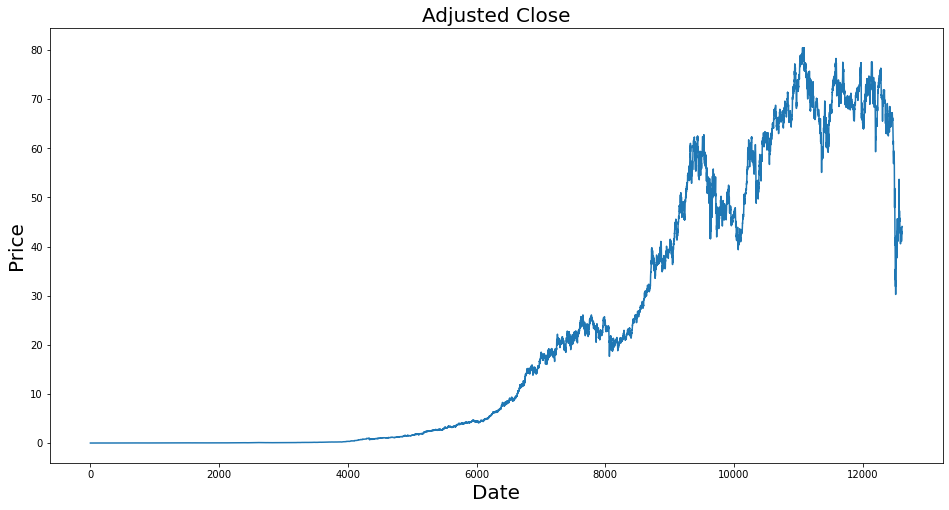

In [7]:
x = df.index
Y = df['Adj Close']

plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close',fontsize=20)
plt.show()


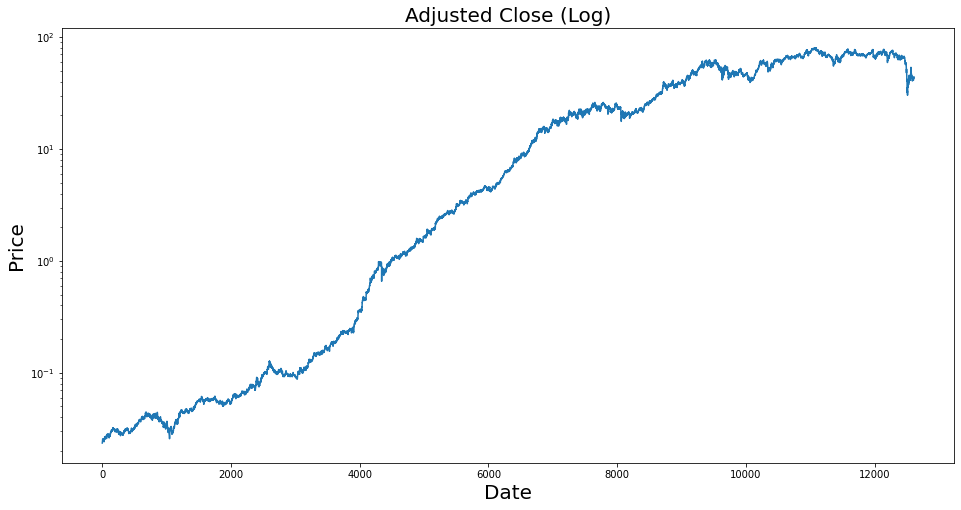

In [8]:
plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close (Log)',fontsize=20)
plt.yscale('log')
plt.show()

In [9]:
df['Adj High'] = (df['Adj Close']/df['Close'])*df['High']
df['Adj Low'] = (df['Adj Close']/df['Close'])*df['Low']
df['Adj Volume'] = df['Volume']

data=df[['Adj Close','Adj Volume','Adj High','Adj Low']]
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low
0,0.023546,2828800,0.023928,0.023498
1,0.023737,2867200,0.023833,0.023498
2,0.023880,768000,0.023928,0.023737
3,0.024358,1558400,0.024406,0.023880
4,0.025122,4928000,0.025218,0.024453


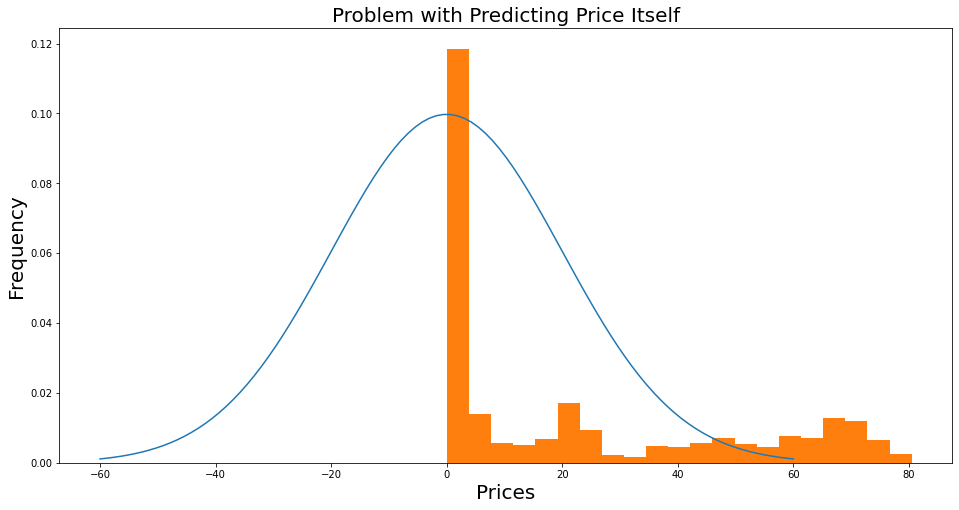

In [10]:
from scipy.stats import norm

mu = 0
sigma = 20 
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

plt.figure(figsize=[16,8])
plt.plot(x,5*norm.pdf(x,loc=mu,scale=sigma))
plt.hist(data['Adj Close'],bins='auto',density=True)
plt.xlabel('Prices',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title('Problem with Predicting Price Itself', fontsize=20)
plt.show()

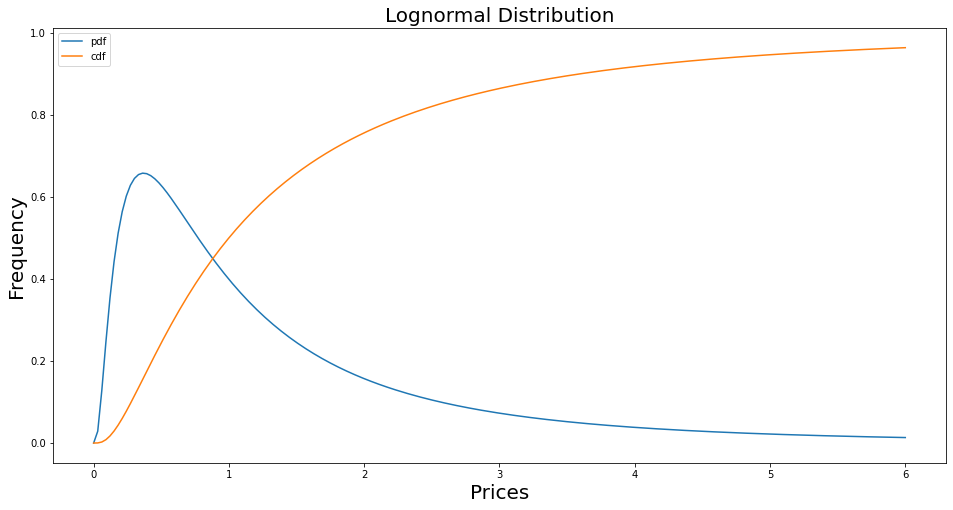

In [11]:
from scipy.stats import lognorm

stddev = 1
mean = 0 
dist=lognorm([stddev],loc=mean)

x = np.linspace(0,6,200)
plt.figure(figsize=[16,8])
plt.plot(x,dist.pdf(x),label='pdf')
plt.plot(x,dist.cdf(x),label='cdf')
plt.xlabel('Prices',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title('Lognormal Distribution', fontsize=20)
plt.legend(loc='best')
plt.show()

## 3. Clean and Prepare Data

In [12]:
dataCopy = data.copy()

data.loc[:,('dailyReturn')] = np.log(dataCopy.loc[:,('Adj Close')]/dataCopy.loc[:,('Adj Close')].shift(1))
data.loc[:,'weeklyReturn'] = np.log(dataCopy.loc[:,'Adj Close']/dataCopy.loc[:,'Adj Close'].shift(5))
data.loc[:,'dailyHL'] = np.log(dataCopy.loc[:,'Adj High']/dataCopy['Adj Low'])
data.loc[:,'weeklyHL'] = np.log(dataCopy.loc[:,'Adj High'].rolling(6).max()/dataCopy.loc[:,'Adj Low'].rolling(6).min())
data.head(12)

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
0,0.023546,2828800,0.023928,0.023498,NaN,NaN,0.018127,NaN
1,0.023737,2867200,0.023833,0.023498,0.008079,NaN,0.014128,NaN
2,0.023880,768000,0.023928,0.023737,0.006006,NaN,0.008016,NaN
3,0.024358,1558400,0.024406,0.023880,0.019819,NaN,0.021762,NaN
4,0.025122,4928000,0.025218,0.024453,0.030884,NaN,0.030772,NaN
5,0.024931,2262400,0.025170,0.024644,-0.007632,0.057156,0.021094,0.070615
6,0.025409,3811200,0.025457,0.025075,0.018991,0.068068,0.015123,0.080057
7,0.025600,4243200,0.025887,0.025313,0.007489,0.069551,0.022389,0.086701
8,0.025361,2841600,0.025504,0.025027,-0.009380,0.040352,0.018904,0.080667
9,0.025313,3043200,0.025409,0.025217,-0.001894,0.007574,0.007547,0.056957


In [13]:
data = data.dropna(how='any')
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
5,0.024931,2262400,0.025170,0.024644,-0.007632,0.057156,0.021094,0.070615
6,0.025409,3811200,0.025457,0.025075,0.018991,0.068068,0.015123,0.080057
7,0.025600,4243200,0.025887,0.025313,0.007489,0.069551,0.022389,0.086701
8,0.025361,2841600,0.025504,0.025027,-0.009380,0.040352,0.018904,0.080667
9,0.025313,3043200,0.025409,0.025217,-0.001894,0.007574,0.007547,0.056957


In [14]:
def toTimeSeries(df,columns,n_trail=1,n_lead=1):
    df = df[columns]
    n_columns=len(columns)
    cols=[]
    names=[]
    
    # Create trailing columns
    for i in range(n_trail,0,-1):
        cols.append(df.shift(i))
        names += [(columns[j]+'(t-%d)'%(i))  for j in range(n_columns)]
        
    # Create leading columns
    for i in range(0,n_lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j]+'(t+%d)'%(i))  for j in range(n_columns)]
        
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    # Clean up NaN rows
    agg.dropna(inplace=True)
    
    return agg

In [15]:
n_trail = 5
n_lead = 5
columns = ['dailyReturn','weeklyReturn','dailyHL','weeklyHL']

reframed = toTimeSeries(data,columns,n_trail,n_lead)
print(reframed.head())

    dailyReturn(t-5)  weeklyReturn(t-5)  dailyHL(t-5)  weeklyHL(t-5)  \
10         -0.007632           0.057156      0.021094       0.070615   
11          0.018991           0.068068      0.015123       0.080057   
12          0.007489           0.069551      0.022389       0.086701   
13         -0.009380           0.040352      0.018904       0.080667   
14         -0.001894           0.007574      0.007547       0.056957   

    dailyReturn(t-4)  weeklyReturn(t-4)  dailyHL(t-4)  weeklyHL(t-4)  \
10          0.018991           0.068068      0.015123       0.080057   
11          0.007489           0.069551      0.022389       0.086701   
12         -0.009380           0.040352      0.018904       0.080667   
13         -0.001894           0.007574      0.007547       0.056957   
14         -0.007574           0.007632      0.011386       0.049173   

    dailyReturn(t-3)  weeklyReturn(t-3)  ...  dailyHL(t+3)  weeklyHL(t+3)  \
10          0.007489           0.069551  ...      0.00955

## 4. Split in Training and Testing Data

In [16]:
values = reframed.values

trainTestSplit = 0.75

mask = np.random.rand(len(values)) < trainTestSplit

train = values[mask,:]
test = values[~mask,:]
print(train.shape)

# Number of features
n_columns = len(columns)
n_features = (n_lead - 1) * n_columns
n_periods = n_trail + 1

# Number of periods in observation
n_obs = n_periods * n_columns

# Assign test and training sets
X_train, Y_train = train[:,0:n_obs], train[:,-n_features:]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))

X_test, Y_test = test[:,0:n_obs], test[:,-n_features:]
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

new_train = []
for i, train in enumerate(Y_train):
    new_train.append(Y_train[i][-n_columns:].tolist())
Y_train = np.array(new_train)

new_test = []
for i, test in enumerate(Y_test):
    new_test.append(Y_test[i][-n_columns:].tolist())
Y_test = np.array(new_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(9350, 44)
(9350, 24)
(9350, 6, 4) (9350, 16) (3247, 6, 4) (3247, 16)
(9350, 6, 4) (9350, 4) (3247, 6, 4) (3247, 4)


## 5. Assemble the Model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


with tf.device('/CPU:0'):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1:])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(len(columns)))
    model.compile(loss='mae',optimizer='Adam')

Using TensorFlow backend.


In [18]:
print(model.summary())
model.get_config()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 50)             11000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 6, 4),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

## 6. Train the Model

In [19]:
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 9350 samples, validate on 3247 samples
Epoch 1/50


InternalError: 2 root error(s) found.
  (0) Internal:  Blas GEMM launch failed : a.shape=(72, 4), b.shape=(4, 200), m=72, n=200, k=4
	 [[{{node lstm_1/while/body/_1/MatMul}}]]
	 [[sub_31/_254]]
  (1) Internal:  Blas GEMM launch failed : a.shape=(72, 4), b.shape=(4, 200), m=72, n=200, k=4
	 [[{{node lstm_1/while/body/_1/MatMul}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_3622]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


## 7. Evaluate the Model

In [ ]:
Y_predicted = model.predict(X_test)
results = pd.DataFrame(Y_test)
col1, col2, col3, col4 = [],[],[],[]

for pred in Y_predicted:
    col1.append(pred[0])
    col2.append(pred[1])
    col3.append(pred[2])
    col4.append(pred[3])

results[2], results[3], results[4], results[5] = col1, col2, col3, col4
results.columns = ['Daily Return','Weekly Return','Predicted Daily', 'Predicted Weekly', 
                   'Daily HL', 'Weekly HL']
results.head()

In [ ]:
results['Prop'] = results['Weekly Return']/results['Predicted Weekly']

results['Correct'] = results['Prop'].apply(lambda x : 1 if x > 0.5 and x < 2 else 0)
results['Correct2'] = (results['Weekly Return']*results['Predicted Weekly']).apply(lambda x : 1 if x > 0 else 0)

print('Direction and Magnitude Accuracy Score: ', results.Correct.sum()/results.Correct.count())
print('Direction Only Accuracy Score: ', results.Correct2.sum()/results.Correct2.count())

In [ ]:
np.corrcoef(results['Weekly Return'], results['Predicted Weekly'])

In [ ]:
results['Risk-Reward'] = results['Predicted Weekly']/results['Weekly HL']
analyze = results.copy(deep=True)

buySignal = analyze['Risk-Reward'].quantile(0.95)
sellSignal = analyze['Risk-Reward'].quantile(0.05)

print('Buy Signal: ', buySignal)
print('Sell Signal: ', sellSignal)

In [ ]:
analyze = analyze[(analyze['Risk-Reward'] > buySignal) | (analyze['Risk-Reward'] <= sellSignal)]
print('Trade Signal x% of the time: ', analyze.shape[0]/results.shape[0])
analyze.head()

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression

X = analyze['Risk Score']
Y = analyze['Weekly Return']

X = X.reshape(len(X),1)
Y = Y.reshape(len(Y),1)

lr = LinearResgression()
lr = lr.fit(X,Y)
preds = lr.predict(X)


from sklearn.metrics import r2_score

print('R^2 Score: ', r2_score(Y,preds))